In [2]:
import legume
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/var/folders/_n/200kljtd2dg7jx4fc971742w0000gn/T/ipykernel_61340/2456332380.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
D = 1
r_holes = 120e-3
eps_slab = 4.1
eps_holes = 1.0
a = 500e-3
theta = np.deg2rad(6.01)  
# Reciprocal lattice vectors of layer 1
G11 = (2*np.pi/(np.sqrt(3)*a)) * np.array([np.sqrt(3), 1])
G12 = (2*np.pi/(np.sqrt(3)*a)) * np.array([np.sqrt(3), -1])

# Rotate to get reciprocal lattice vectors of layer 2
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]])
G21 = R @ G11
G22 = R @ G12

# Moiré reciprocal vectors (difference)
g1_moire = G11 - G21
g2_moire = G12 - G22


G_moire = np.column_stack([g1_moire, g2_moire])
A_moire = 2*np.pi * np.linalg.inv(G_moire.T) 

A1 = A_moire[:,0]
A2 = A_moire[:,1]

In [4]:
df = pd.read_csv("moire_points.csv")
x = np.array(df.x_cent)
y = np.array(df.y_cent)

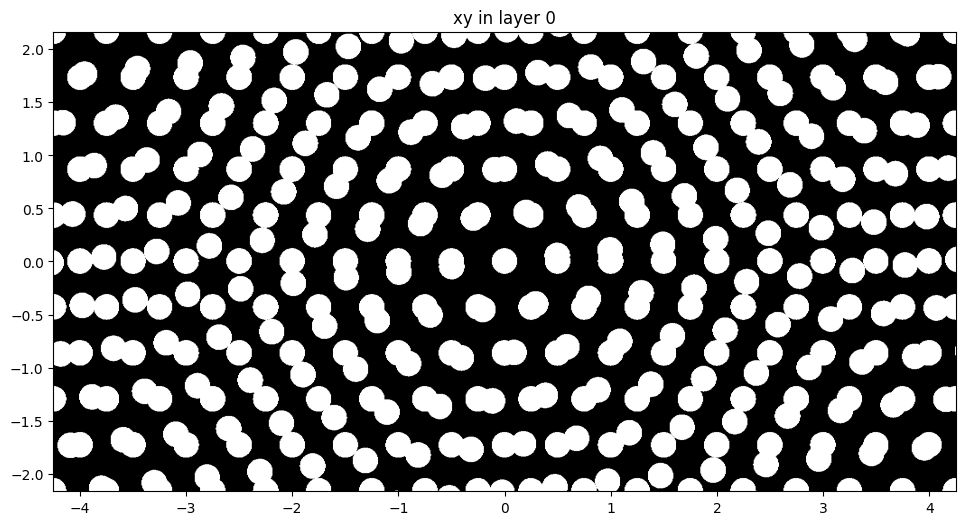

In [5]:
lattice = legume.Lattice(A1, A2)
phc = legume.PhotCryst(lattice, eps_l=1., eps_u=1.)
phc.add_layer(d=D, eps_b=eps_slab)
for i in range(len(x)):
    circle = legume.Circle(eps=eps_holes, x_cent=x[i], y_cent=y[i], r=r_holes)
    phc.add_shape(circle)
legume.viz.structure(phc, yz=False, figsize=10., Nx = 1000, Ny = 1000, cbar=False)

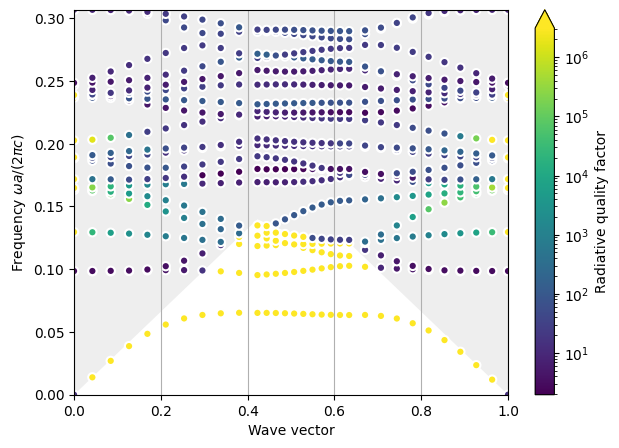

In [6]:
gme = legume.GuidedModeExp(phc, gmax=6)
Gamma = [0,0]
K = (g1_moire + g2_moire)/3
M = g1_moire/2
k_points = [Gamma, K, M, Gamma]
path = lattice.bz_path(k_points, [10,10,10])
gme.run(kpoints=path['kpoints'],
        gmode_inds=[0, 3],
        numeig=20,
        verbose=False)
fig, ax = plt.subplots(1, figsize = (7, 5))
legume.viz.bands(gme, figsize=(5,5), k_units=True, Q=True, ax=ax)
# ax.set_xticks(path['k_indexes'])
# ax.set_xticklabels(path['labels'])
ax.xaxis.grid('True')

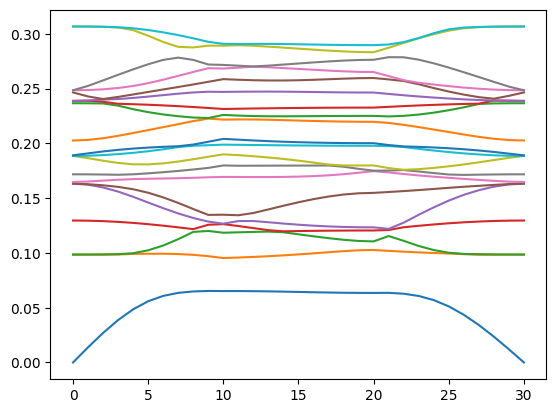

In [11]:
plt.plot(gme.freqs)